# Attention Scoring Functions

$$
f(\mathrm{\mathbf q}) = \mathrm{softmax}\left(a(\mathbf{q}, \mathbf{k})\right) \mathbf v 
$$

> 我们把`softmax`里面的函数称为注意力评分函数，回顾`13_attention_3_more.ipynb`中的Scaled Dot-Product Attention，那么对于它而言，注意力评分函数就是点积函数，即$a(\mathbf{q}, \mathbf{k}) = \frac{\mathbf q \mathbf k^\top }{\sqrt{d}}$，而对于Bahdanau Attention而言，注意力评分函数就是一个前馈神经网络，即$a(\mathbf{q}, \mathbf{k}) = \mathbf{v}^\top \tanh(\mathbf{W}_1 \mathbf{q} + \mathbf{W}_2 \mathbf{k})$；下面我们会一一介绍这些注意力评分函数。

这一节我们将介绍注意力机制中的注意力评分函数（个人理解就是换着花样刻画相似度的函数）

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## Convenience Functions

### Masked Softmax Operation

In [4]:
def masked_softmax(X, valid_lens):  #@save
    """
    Perform softmax operation by masking elements on the last axis.
    
    Parameters
    ----------
    X : torch.Tensor
        3D tensor whose last axis has values to be masked.
    valid_lens : torch.Tensor
        1D or 2D tensor consisting of valid lengths of sequences.
    """
    def _sequence_mask(
            X, 
            valid_len, 
            value=0
        ):
        maxlen = X.size(1)
        mask = torch.arange(
            (maxlen),
            dtype=torch.float32,
            device=X.device
        )[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(
                valid_lens, shape[1]
            )
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(
            X.reshape(-1, shape[-1]), 
            valid_lens, 
            value=-1e6
        )
        return nn.functional.softmax(
            X.reshape(shape), dim=-1
        )

In [6]:
torch.rand(2, 2, 4)

tensor([[[0.3125, 0.3033, 0.0590, 0.7563],
         [0.9133, 0.0208, 0.8204, 0.7746]],

        [[0.2695, 0.4882, 0.9605, 0.7451],
         [0.9038, 0.5589, 0.1029, 0.9626]]])

In [5]:
masked_softmax(
    torch.rand(2, 2, 4), 
    torch.tensor([2, 3])
)

tensor([[[0.5783, 0.4217, 0.0000, 0.0000],
         [0.5734, 0.4266, 0.0000, 0.0000]],

        [[0.3211, 0.2258, 0.4531, 0.0000],
         [0.2359, 0.4971, 0.2670, 0.0000]]])

In [7]:
masked_softmax(
    torch.rand(2, 2, 4), 
    torch.tensor(
        [[1, 3], 
         [2, 4]]
    )
)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2298, 0.4006, 0.3696, 0.0000]],

        [[0.4700, 0.5300, 0.0000, 0.0000],
         [0.2666, 0.2630, 0.2303, 0.2400]]])

### Batch Matrix Multiplication

$$
\begin{split}\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.\end{split}
$$

$$
\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.
$$

In [9]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K).shape == (2, 3, 6)

True

## Scaled Dot Product Attention

$$
\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.
$$

In [10]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(
            queries, 
            keys.transpose(1, 2)
        ) / math.sqrt(d)
        self.attention_weights = masked_softmax(
            scores, 
            valid_lens
        )
        return torch.bmm(
            self.dropout(self.attention_weights), 
            values
        )

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.2)
attention.eval()
attention(
    queries, 
    keys, 
    values, 
    valid_lens
).shape == (2, 1, 4)

True

In [18]:
import matplotlib.pyplot as plt

def show_attention(
        attention,
        xlabel = 'Keys',
        ylabel = 'Queries',
        title = 'Attention weights'
    ):
    """
    画出注意力权重图

    Parameters
    ----------
    @param attention: torch.Tensor
        attention weights, shape (m, n)
    """

    fig = plt.figure(figsize=(5, 5))

    pcm = plt.imshow(
        attention.detach().numpy(), 
        cmap='Reds'
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    fig.colorbar(pcm, shrink=0.7)
    plt.show()

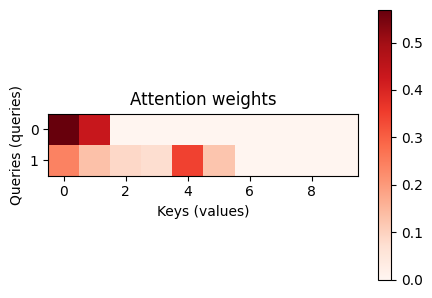

In [19]:
show_attention(
    attention.attention_weights.reshape((2, 10)),
    xlabel='Keys (values)', 
    ylabel='Queries (queries)'
)

## Additive Attention

当$\mathbf q, \mathbf k$的维度不同的时候，我们可以照样可以衡量两个向量之间的相似度，我们简单通过将两个向量通过对应的线性变换到同一空间，然后再计算它们的相似度，即

$$
a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},
$$

where
- $\mathbf W_q\in\mathbb R^{h\times q}$
- $\mathbf W_k\in\mathbb R^{h\times k}$
- $\mathbf w_v\in\mathbb R^{h}$
- $\mathbf q\in\mathbb R^{q}$
- $\mathbf k\in\mathbb R^{k}$

> 注意这里我们也可以用`Linear`，只需要把`nn.Linear`的`bias`设置为`False`即可。下面代码中的`LazyLinear`是默认不需要输入维度的线性变换，它会根据输入的维度自动计算。

In [23]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(
            scores, valid_lens
        )
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(
            self.dropout(self.attention_weights), 
            values
        )

In [24]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens).shape == (2, 1, 4)

c:\Users\dongl\.conda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


True

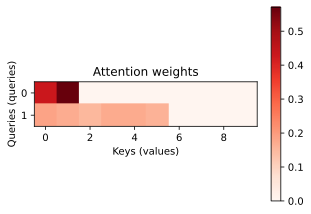

In [25]:
show_attention(
    attention.attention_weights.reshape((2, 10)),
    xlabel='Keys (values)', 
    ylabel='Queries (queries)'
)